In [1]:
import celldancer as cd
import anndata
import pandas as pd
import numpy as np
import scipy as sp
import os

In [2]:
dataset = "Braindev"
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f"{root}/data/{dataset}_pp.h5ad")

In [5]:
data_path = f"{root}/data/celldancer/{dataset}"
os.makedirs(data_path, exist_ok=True)
N, G = adata.shape
# df = cd.adata_to_df_with_embed(adata,
#                                cell_type_para='clusters',
#                                embed_para='X_umap',
#                                save_path=f"{data_path}/{dataset}.csv")
df = pd.read_csv(f"{data_path}/{dataset}.csv")

In [6]:
df_loss , df = cd.velocity(df,
                           max_epoches=200,
                           permutation_ratio=0.125,
                           n_jobs=8,
                           save_path=data_path)

Using /scratch/blaauw_root/blaauw1/gyichen/data/celldancer/Braindev/cellDancer_velocity_2023-04-06 13-46-01 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  250  portions.



Velocity Estimation:  87%|████████▋ | 217/250 [1:22:35<12:52, 23.42s/it]


Velocity Estimation: 100%|██████████| 250/250 [1:34:58<00:00, 23.63s/it]
                                                                        

In [7]:
n_neigh = adata.uns['neighbors']['indices'].shape[1]
df = cd.compute_cell_velocity(cellDancer_df=df,
                              projection_neighbor_choice="gene",
                              expression_scale='power10',
                              projection_neighbor_size=n_neigh,
                              speed_up=(100, 100))

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████| 22960/22960 [00:03<00:00, 7056.63it/s] 


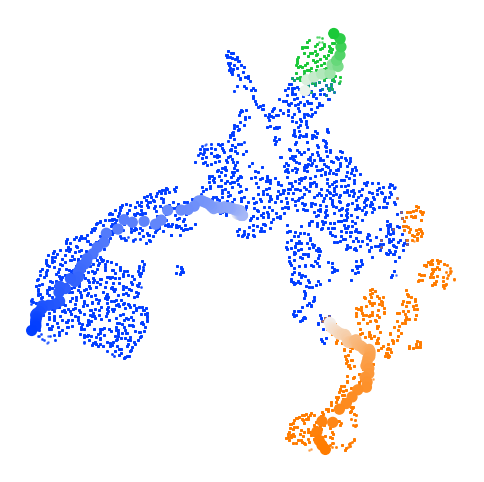

There are 3 clusters.
[0 1 2]
--- 856.5963447093964 seconds ---


In [8]:
# estimate pseudotime
dt = 0.05
n_repeats = 10
t_total = {dt: int(10/dt)}
df = cd.pseudo_time(cellDancer_df=df,
                    grid=(30, 30),
                    dt=dt,
                    t_total=t_total[dt],
                    n_repeats=n_repeats,
                    speed_up=(100, 100),
                    n_paths=3,
                    plot_long_trajs=True,
                    psrng_seeds_diffusion=[i for i in range(n_repeats)],
                    n_jobs=8)

In [9]:
df.to_csv(f"{data_path}/{dataset}_out.csv")

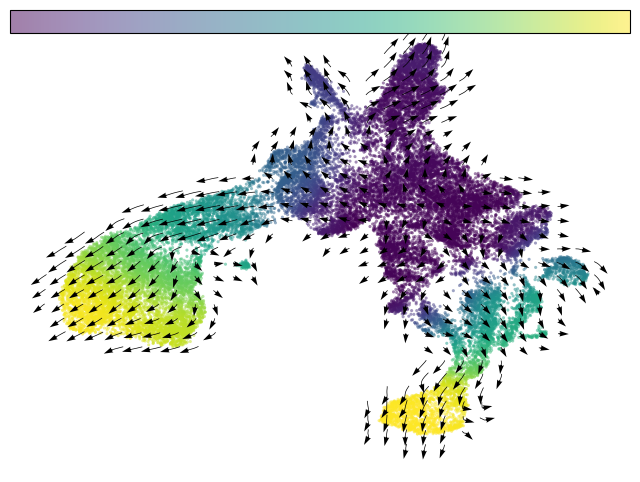

In [10]:
import matplotlib.pyplot as plt
import celldancer.cdplt as cdplt
fig, ax = plt.subplots(figsize=(8,6))
im=cdplt.scatter_cell(ax,
                      df,
                      colors='pseudotime',
                      alpha=0.5,
                      velocity=True)
ax.axis('off')
fig.savefig(f"{data_path}/cd_time_{dataset}.png")

# Save results to .h5ad file

In [2]:
dataset = "Braindev"
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f"{root}/data/{dataset}_pp.h5ad")
df = pd.read_csv(f"{root}/data/celldancer/{dataset}/{dataset}_out.csv")

In [3]:
N, G = adata.shape

time = df["pseudotime"].to_numpy().reshape(G, N).T

adata.layers["cd_alpha"] = df["alpha"].to_numpy().reshape(G, N).T
adata.layers["cd_beta"] = df["beta"].to_numpy().reshape(G, N).T
adata.layers["cd_gamma"] = df["gamma"].to_numpy().reshape(G, N).T
adata.layers["cd_velocity_u"] = (df["unsplice_predict"].to_numpy().reshape(G, N)
                                 - df["unsplice"].to_numpy().reshape(G, N)).T
adata.layers["cd_velocity"] = (df["splice_predict"].to_numpy().reshape(G, N)
                               - df["splice"].to_numpy().reshape(G, N)).T
adata.obs["cd_time"] = time[:, 0]

data_path = f"{root}/data/celldancer/{dataset}"
adata.write_h5ad(f"{data_path}/{dataset}.h5ad")